In [35]:
import collections

import helper
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM,GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Verify GPU

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5826549409722484417
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4501131684181163245
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17885170519654364562
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6861212877
locality {
  bus_id: 1
  links {
  }
}
incarnation: 604882935036126788
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Dataset

### Load Dataset

In [3]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


In [4]:
for sample_i in range(5):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .
small_vocab_en Line 3:  california is usually quiet during march , and it is usually hot in june .
small_vocab_fr Line 3:  california est généralement calme en mars , et il est généralement chaud en juin .
small_vocab_en Line 4:  the united states is sometimes mild during june , and it is cold in september .
small_vocab_fr Line 4:  les états-unis est parfois légère en juin , et il fait froid en septembre .
small_vocab_en Line 5:  your least liked fruit is the grape , but my least liked is the apple .
small_vocab_fr Line 5:  votre moins aimé fruit est le raisin , m

### Vocabulary

In [5]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"
()
1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


## Preprocess

### Tokenize

In [6]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    
    # Initialize tokenizer
    tokenizer = Tokenizer()
    # Fit tokenizer on text
    tokenizer.fit_on_texts(x)
    # Tokenize the text
    tok_x = tokenizer.texts_to_sequences(x)
    return tok_x, tokenizer

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'a': 3, 'brown': 4, 'lazy': 8, 'short': 20, 'prize': 17, 'sentence': 21, 'this': 18, 'of': 14, 'jumps': 6, 'fox': 5, 'dog': 9, 'jove': 11, 'by': 10, 'won': 16, 'lexicography': 15, 'quick': 2, 'study': 13, 'the': 1, 'my': 12, 'over': 7, 'is': 19}
()
Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Plot length of Sentences

In [33]:
english_sentences[0].split()

['new',
 'jersey',
 'is',
 'sometimes',
 'quiet',
 'during',
 'autumn',
 ',',
 'and',
 'it',
 'is',
 'snowy',
 'in',
 'april',
 '.']

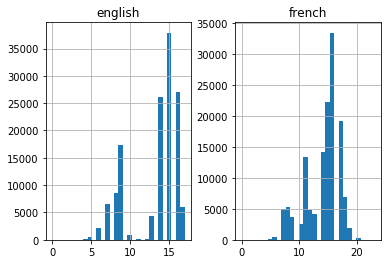

In [36]:
english_sentence_count = []
french_sentence_count = []

for i in range(len(english_sentences)):
    english_sentence_count.append(len(english_sentences[i].split()))
    french_sentence_count.append(len(french_sentences[i].split()))
    
length_df = pd.DataFrame({'english':english_sentence_count, 'french':french_sentence_count})

length_df.hist(bins = 30)
plt.show()

### Padding

In [7]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    
    if length == None:
        length = max([len(sentence) for sentence in x])
        
    x = pad_sequences(x, maxlen=length, padding='post')
    return x

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline

In [8]:
def preprocess_seq2seq(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    # append <START> and <STOP> token to the target y (French sentences)
    # append <STOP> token to the input y (French sentences)
    new_input_y = []
    new_target_y = []
    for sent in y:
        new_input_sent = "sostok " + sent + " eostok"
        new_target_sent = sent + " eostok"
        new_input_y.append(new_input_sent)
        new_target_y.append(new_target_sent)
    
    preprocess_x, x_tk = tokenize(x)
    preprocess_input_y, y_tk = tokenize(new_input_y)
    preprocess_target_y = y_tk.texts_to_sequences(new_target_y)

    preprocess_x = pad(preprocess_x)
    preprocess_input_y = pad(preprocess_input_y)
    max_input_y_len = max([len(sentence) for sentence in preprocess_input_y])
    preprocess_target_y = pad(preprocess_target_y, length=max_input_y_len)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    #preprocess_input_y = preprocess_input_y.reshape(preprocess_input_y.shape[0],preprocess_input_y.shape[1], 1)
    preprocess_target_y = preprocess_target_y.reshape(preprocess_target_y.shape[0], preprocess_target_y.shape[1], 1)

    return preprocess_x, preprocess_input_y, preprocess_target_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences_input, preproc_french_sentences_target, english_tokenizer, french_tokenizer =\
    preprocess_seq2seq(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences_input.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed for Sequence to Sequence Model')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed for Sequence to Sequence Model
('Max English sentence length:', 15)
('Max French sentence length:', 23)
('English vocabulary size:', 199)
('French vocabulary size:', 347)


In [9]:
preproc_english_sentences

array([[17, 23,  1, ..., 44,  0,  0],
       [ 5, 20, 21, ..., 51,  2, 45],
       [22,  1,  9, ..., 34,  0,  0],
       ...,
       [24,  1, 10, ..., 54,  0,  0],
       [ 5, 84,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [10]:
preproc_french_sentences_input

array([[  2,  37,  36, ...,   0,   0,   0],
       [  2,   6,  34, ...,   0,   0,   0],
       [  2, 103,   1, ...,   0,   0,   0],
       ...,
       [  2,   9,  35, ...,   0,   0,   0],
       [  2,  86,   1, ...,   0,   0,   0],
       [  2,   3,   0, ...,   0,   0,   0]], dtype=int32)

In [11]:
preproc_french_sentences_target

array([[[ 37],
        [ 36],
        [  1],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  6],
        [ 34],
        [ 33],
        ...,
        [  0],
        [  0],
        [  0]],

       [[103],
        [  1],
        [ 14],
        ...,
        [  0],
        [  0],
        [  0]],

       ...,

       [[  9],
        [ 35],
        [  1],
        ...,
        [  0],
        [  0],
        [  0]],

       [[ 86],
        [  1],
        [ 22],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  3],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]]], dtype=int32)

In [12]:
preproc_english_sentences.shape

(137861, 15)

In [13]:
preproc_french_sentences_input.shape

(137861, 23)

In [14]:
preproc_french_sentences_target.shape

(137861, 23, 1)

In [15]:
preproc_french_sentences_input[0]

array([  2,  37,  36,   1,  10,  69,  39,  13,  26,   8,   5,   1, 114,
         4,  52,   3,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [16]:
preproc_french_sentences_target[0]

array([[ 37],
       [ 36],
       [  1],
       [ 10],
       [ 69],
       [ 39],
       [ 13],
       [ 26],
       [  8],
       [  5],
       [  1],
       [114],
       [  4],
       [ 52],
       [  3],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0]], dtype=int32)

### Ids Back to Text

In [17]:
french_index_to_words = {id: word for word, id in french_tokenizer.word_index.items()}
french_index_to_words[0] = '<PAD>'

In [18]:
french_words_to_index = {word: id for word, id in french_tokenizer.word_index.items()}
french_words_to_index['<PAD>'] = 0

In [19]:
french_index_to_words

{0: '<PAD>',
 1: 'est',
 2: 'sostok',
 3: 'eostok',
 4: 'en',
 5: 'il',
 6: 'les',
 7: 'mais',
 8: 'et',
 9: 'la',
 10: 'parfois',
 11: 'jamais',
 12: 'le',
 13: "l'",
 14: 'g\xc3\xa9n\xc3\xa9ralement',
 15: 'moins',
 16: 'aim\xc3\xa9',
 17: 'au',
 18: 'fruit',
 19: 'pr\xc3\xa9f\xc3\xa9r\xc3\xa9',
 20: 'agr\xc3\xa9able',
 21: 'froid',
 22: 'son',
 23: 'chaud',
 24: 'de',
 25: 'plus',
 26: 'automne',
 27: 'mois',
 28: '\xc3\xa0',
 29: 'elle',
 30: 'citrons',
 31: 'paris',
 32: 'inde',
 33: 'unis',
 34: '\xc3\xa9tats',
 35: 'france',
 36: 'jersey',
 37: 'new',
 38: 'chine',
 39: 'pendant',
 40: 'pamplemousse',
 41: 'mon',
 42: 'votre',
 43: 'juin',
 44: 'printemps',
 45: 'janvier',
 46: 'hiver',
 47: 'mars',
 48: '\xc3\xa9t\xc3\xa9',
 49: 'mai',
 50: 'septembre',
 51: 'juillet',
 52: 'avril',
 53: 'novembre',
 54: 'd\xc3\xa9cembre',
 55: 'f\xc3\xa9vrier',
 56: 'octobre',
 57: 'aime',
 58: 'ao\xc3\xbbt',
 59: 'merveilleux',
 60: 'relaxant',
 61: 'doux',
 62: 'humide',
 63: 'notre',
 64: '

In [20]:
french_words_to_index

{'<PAD>': 0,
 'a': 120,
 'agr\xc3\xa9able': 20,
 'aimait': 145,
 'aime': 57,
 'aiment': 126,
 'aimeraient': 316,
 'aimez': 132,
 'aimons': 128,
 'aim\xc3\xa9': 16,
 'aim\xc3\xa9e': 244,
 'aim\xc3\xa9s': 208,
 'aller': 125,
 'allez': 285,
 'allions': 340,
 'allons': 284,
 'all\xc3\xa9': 225,
 'all\xc3\xa9e': 236,
 'all\xc3\xa9s': 235,
 'amusant': 199,
 'anglais': 190,
 'animal': 111,
 'animaux': 143,
 'ao\xc3\xbbt': 58,
 'appr\xc3\xa9ci\xc3\xa9': 339,
 'as': 342,
 'at': 290,
 'au': 17,
 'automne': 26,
 'automobile': 195,
 'aux': 175,
 'avez': 233,
 'avons': 302,
 'avril': 52,
 'banane': 89,
 'bananes': 77,
 'beau': 70,
 'belle': 106,
 'bien': 251,
 'blanc': 174,
 'blanche': 157,
 'bleu': 168,
 'bleue': 164,
 'brillant': 156,
 'brillante': 176,
 'b\xc3\xa9nigne': 323,
 "c'est": 306,
 'california': 103,
 'californie': 64,
 'calme': 69,
 'camion': 112,
 'ce': 117,
 'cet': 194,
 'cette': 123,
 'chat': 215,
 'chats': 266,
 'chaud': 23,
 'chaude': 127,
 'chaux': 88,
 'cher': 121,
 'cheval': 2

In [21]:
french_words_to_index['sostok']

2

In [22]:
french_words_to_index['eostok']

3

## Model

In [23]:
hidden_size = 512
learning_rate = 1e-3
embedding_size = 300

encoder_inputs = Input(shape=(None,))#Input(shape=(max_text_len,))

# embedding layer for encoder
enc_embed_out = Embedding(input_dim=english_vocab_size,\
                          output_dim=embedding_size,\
                          input_length=max_english_sequence_length
                         )(encoder_inputs)
#encoder lstm 1
#encoder_lstm1 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_lstm1 = LSTM(hidden_size,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_embed_out)

#encoder lstm 2
#encoder_lstm2 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# embedding layer for decoder
dec_emb_layer = Embedding(input_dim=french_vocab_size,\
                          output_dim=embedding_size#,\
                          #input_length=max_french_sequence_length
                        )
dec_emb_out = dec_emb_layer(decoder_inputs)

# decoder lstm 1
#decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_outputs1, decoder_h1, decoder_c1 = decoder_lstm(dec_emb_out,initial_state=[state_h2, state_c2])

# decoder lstm 1
#decoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
#decoder_outputs2, decoder_h2, decoder_c2 = decoder_lstm2(decoder_outputs1)

# dense layer
decoder_dense = TimeDistributed(Dense(french_vocab_size, activation='softmax'))
logits = decoder_dense(decoder_outputs1)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=logits)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 300)      59700       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 15, 512), (N 1665024     embedding_1[0][0]                
_____________________________________

In [24]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate)
             )

model.fit([preproc_english_sentences, preproc_french_sentences_input], preproc_french_sentences_target,
          batch_size=1024,
          epochs=50,
          validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 110288 samples, validate on 27573 samples
Epoch 1/50
110288/110288 [==============================] - 118s 1ms/step - loss: 2.3727 - val_loss: nan
Epoch 2/50
110288/110288 [==============================] - 104s 946us/step - loss: 0.8545 - val_loss: nan
Epoch 3/50
110288/110288 [==============================] - 101s 920us/step - loss: 0.5481 - val_loss: nan
Epoch 4/50
110288/110288 [==============================] - 109s 984us/step - loss: 0.4547 - val_loss: nan
Epoch 5/50
110288/110288 [==============================] - 103s 930us/step - loss: 0.3945 - val_loss: nan
Epoch 6/50
110288/110288 [==============================] - 107s 969us/step - loss: 0.3195 - val_loss: nan
Epoch 7/50
110288/110288 [==============================] - 117s 1ms/step - loss: 0.2354 - val_loss: nan
Epoch 8/50
110288/110288 [==============================] - 112s 1ms/step - loss: 0.1557 - val_loss: nan
Epoch 9/50
110288/110288 [=========================

In [29]:
# Inference
#encoder_states = [state_h2, state_c2]
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output2, state_h2, state_c2])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb = dec_emb_layer(decoder_inputs)

decoder_outputs, dec_state_h, dec_state_c = decoder_lstm(
    dec_emb, initial_state=decoder_states_inputs)
decoder_states = [dec_state_h, dec_state_c]
# may need to change to TimeDistributed
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [37]:
def decode_sequence(input_seq, french_tokenizer):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Populate the first word of target sequence with the start word.
    target_seq = french_tokenizer.texts_to_sequences(['sostok'])

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    num_words_generated = 0
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_h, e_c])
        #print(output_tokens[0, -1, :])
        #print(output_tokens.shape)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = french_index_to_words[sampled_token_index]
        #print(sampled_char)
        num_words_generated += 1
        if (sampled_char != 'eostok') and (sampled_char != '<PAD>'):
            decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if ((sampled_char == 'eostok') or (num_words_generated >= max_french_sequence_length)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        #target_seq = np.zeros((1, 1, num_decoder_tokens))
        #target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        e_h = h
        e_c = c

    return decoded_sentence

In [38]:
for i in range(30):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = preproc_english_sentences[i]
    decoded_sentence = decode_sequence(input_seq, french_tokenizer)
    print('-')
    print('Original English sentence: {}'.format(english_sentences[i]))
    print('Original French sentence: {}'.format(french_sentences[i]))
    print('Translated French sentence: {}'.format(decoded_sentence))

-
Original English sentence: new jersey is sometimes quiet during autumn , and it is snowy in april .
Original French sentence: new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
Translated French sentence:  préféré est la pomme
-
Original English sentence: the united states is usually chilly during july , and it is usually freezing in november .
Original French sentence: les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .
Translated French sentence:  préféré est la pomme
-
Original English sentence: california is usually quiet during march , and it is usually hot in june .
Original French sentence: california est généralement calme en mars , et il est généralement chaud en juin .
Translated French sentence:  est le gel en octobre
-
Original English sentence: the united states is sometimes mild during june , and it is cold in september .
Original French sentence: les états-unis est parfois légère en juin , et il fait fr

In [46]:
np.zeros((1,1))

array([[0.]])

In [54]:
preproc_english_sentences[0]

array([17, 23,  1,  8, 67,  4, 39,  7,  3,  1, 55,  2, 44,  0,  0],
      dtype=int32)

In [98]:
preproc_english_sentences[0].shape

(15,)

In [ ]:
preproc_french_sentences_input

In [25]:
preproc_french_sentences_input[0]

array([[  2],
       [ 37],
       [ 36],
       [  1],
       [ 10],
       [ 69],
       [ 39],
       [ 13],
       [ 26],
       [  8],
       [  5],
       [  1],
       [114],
       [  4],
       [ 52],
       [  3],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0]], dtype=int32)

In [24]:
preproc_french_sentences_input[0:1]

array([[[  2],
        [ 37],
        [ 36],
        [  1],
        [ 10],
        [ 69],
        [ 39],
        [ 13],
        [ 26],
        [  8],
        [  5],
        [  1],
        [114],
        [  4],
        [ 52],
        [  3],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=int32)

In [45]:
french_tokenizer.texts_to_sequences(['<START>'])

[[2]]

In [50]:
french_tokenizer.texts_to_sequences(["<START> new jersey est parfois calme pendant l' automne <END>", 'et il est neigeux en avril <END>'])

[[2, 37, 36, 1, 10, 69, 39, 13, 26, 3], [8, 5, 1, 114, 4, 52, 3]]

In [43]:
french_sentences

["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .",
 'les \xc3\xa9tats-unis est g\xc3\xa9n\xc3\xa9ralement froid en juillet , et il g\xc3\xa8le habituellement en novembre .',
 'california est g\xc3\xa9n\xc3\xa9ralement calme en mars , et il est g\xc3\xa9n\xc3\xa9ralement chaud en juin .',
 'les \xc3\xa9tats-unis est parfois l\xc3\xa9g\xc3\xa8re en juin , et il fait froid en septembre .',
 'votre moins aim\xc3\xa9 fruit est le raisin , mais mon moins aim\xc3\xa9 est la pomme .',
 "son fruit pr\xc3\xa9f\xc3\xa9r\xc3\xa9 est l'orange , mais mon pr\xc3\xa9f\xc3\xa9r\xc3\xa9 est le raisin .",
 'paris est relaxant en d\xc3\xa9cembre , mais il est g\xc3\xa9n\xc3\xa9ralement froid en juillet .',
 'new jersey est occup\xc3\xa9 au printemps , et il est jamais chaude en mars .',
 'notre fruit est moins aim\xc3\xa9 le citron , mais mon moins aim\xc3\xa9 est le raisin .',
 'les \xc3\xa9tats-unis est parfois occup\xc3\xa9 en janvier , et il est parfois chaud en novembr

In [ ]:
logits_to_text(, tokenizer)